<a href="https://colab.research.google.com/github/kubernetes-world/3666-ANLP-Predicting-ECB-Monetary-Policy/blob/main/LSTM-Final-SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diskcache
!pip install boto3
!pip install scikeras

In [ ]:
import os
import pandas as pd
import numpy as np

import unicodedata

from itertools import groupby
from unicodedata import category as unicat

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, pos_tag
from nltk.chunk import tree2conlltags
from nltk.chunk.regexp import RegexpParser
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.utils import pad_sequences

In [ ]:
from google.colab import userdata
import boto3

s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
s3.download_file("3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz", "KeyphraseExtractor.cache.tar.gz")
s3.download_file("3666-applied-nlp", "rate_speeches.sent_tokenize.parquet.gzip", "rate_speeches.sent_tokenize.parquet.gzip")


In [ ]:
!tar zxvf KeyphraseExtractor.cache.tar.gz

In [ ]:

from diskcache import Cache
cache = Cache('KeyphraseExtractor.cache')


In [ ]:
# from joblib import Memory
# location = 'keyphrase_extractor_cachedir'
# memory = Memory(location, verbose=0)

from tqdm import tqdm

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures: int, doclen: int):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen
        # self.normalize = memory.cache(self.normalize)
        # self.extract_candidate_phrases = memory.cache(self.extract_candidate_phrases)

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    # NOTE: wrap with memoizing function using cache
    # repeated calls with the same arguments will lookup result in cache and avoid function evaluation.
    @cache.memoize()
    def extract_candidate_phrases(self, sents):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        result = []
        for sent in sents:
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                # print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                # yield phrase # joblib.Memory can't cache generators
                result.append(phrase)
        return result

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        # print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        # print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc if keyphrase in lexicon.keys()]

    def transform(self, documents):
      keydocs = [list(self.extract_candidate_phrases(doc)) for doc in tqdm(documents)]
      lexicon = self.get_lexicon(keydocs)
      clipped = [list(self.clip(keydoc, lexicon)) for keydoc in keydocs]
      return pad_sequences(clipped, maxlen=self.doclen)


In [ ]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print("Data Shape Before LSTM:", X.shape)
        # print("Sample Data Before LSTM:", X[0])  # print a sample
        return X


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input

def create_lstm_model(vocab_size: int, input_length: int, num_classes: int, compile_loss: str):
    model = Sequential([
        Input(shape=(input_length,), name="input_layer"),  # explicit input layer
        Embedding(input_dim=vocab_size, output_dim=128, name="embedding_layer"),
        LSTM(128, return_sequences=True, name="lstm_layer_1"),
        Dropout(0.2, name="dropout_layer_1"),
        LSTM(64, name="lstm_layer_2"),
        Dropout(0.2, name="dropout_layer_2"),
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    model.compile(optimizer='adam', loss=compile_loss, metrics=['accuracy'])
    return model


# Load prepared data and initialize `X`, `y`

In [ ]:

RATE_SPEECHES_TOKENIZED_FILE = 'rate_speeches.sent_tokenize.parquet.gzip'
assert os.path.exists(RATE_SPEECHES_TOKENIZED_FILE), f"file not present: {RATE_SPEECHES_TOKENIZED_FILE}"

rate_speeches = pd.read_parquet(RATE_SPEECHES_TOKENIZED_FILE)
print(f"rate_speeches.shape: {rate_speeches.shape}")


rate_speeches.shape: (3434, 17)


It is acceptable to call `label_encoder.fit_transform(y)` on the entire set of labels (`Direction` values) because `LabelEncoder` is a simple transformation that maps categorical values to numerical labels:

- **It does not learn any information about the dataset beyond the unique classes. However, there are nuances to consider.**


In [ ]:
from sklearn.preprocessing import LabelEncoder

X = rate_speeches["extracted_text"]
print(f"X.shape: {X.shape}")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(rate_speeches["Direction"])  # integer encoding
print(f"y_encoded.shape: {y.shape}")


X.shape: (3434,)
y_encoded.shape: (3434,)


In [ ]:
# keyphrase_extractor = KeyphraseExtractor(nfeatures=10000, doclen=100)

# # build cache
# keyphrase_extractor.fit_transform(X)

In [ ]:
# !tar -cvzf KeyphraseExtractor.cache.tar.gz KeyphraseExtractor.cache

In [ ]:
# from google.colab import userdata
# import boto3

# s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
# s3.upload_file("KeyphraseExtractor.cache.tar.gz", "3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz")


In [ ]:
# keyphrase_extractor.fit_transform(X)

# Choices for `n_splits`

## 5-Fold Cross-Validation:
- Most commonly used.
- Provides a good balance between bias and variance of the performance estimate.

## 10-Fold Cross-Validation:
- Preferred when data is limited and computational cost is acceptable.
- Offers slightly more robust performance estimates but increases computation time.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# dynamically determine n_splits based on class distribution
min_class_size = rate_speeches["Direction"].value_counts().min()
print(f"min_class_size: {min_class_size}")

n_splits = min(10, min_class_size)  # use up to 10 splits or the smallest class size
print(f"Using {n_splits}-Fold Cross-Validation")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


min_class_size: 252
Using 10-Fold Cross-Validation


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Standard `sklearn.pipeline.Pipeline`

In [ ]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from joblib import Memory

#-- no longer needed since the results from KeyphraseExtractor have already been cached
# memory_sparse = Memory(location="cache_directory_sparse", verbose=0)

pipeline_scce = Pipeline([
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1)
    )
])


In [ ]:

scores = cross_val_score(pipeline_scce, X_train, y_train, cv=skf, scoring="accuracy")


In [ ]:
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")


In [ ]:

# Final Evaluation on Test Set
pipeline_scce.fit(X_train, y_train)
y_pred = pipeline_scce.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Synthetic Minority Over-sampling TEchnique (`SMOTE`) for imbalanced data

## Cross-Validation:

- Perform cross-validation with a pipeline to ensure that `SMOTE` is applied only on the training data in each fold.

## Use `imblearn.pipeline.Pipeline`:

- The `Pipeline` class in `imblearn` is specifically designed for scenarios where the pipeline modifies both X and y, such as oversampling with `SMOTE`.

## The `SMOTE` pipeline step:

- We place SMOTE after the `KeyphraseExtractor` preprocessing steps (as we would do with scaling or encoding) to ensure `SMOTE` operates on the transformed data.

## Avoiding data leakage:

- When using `Pipeline` with `SMOTE`, oversampling is applied only to the training folds during cross-validation.
- This avoids data leakage into the validation set, which would inflate performance metrics.


In [ ]:
from scikeras.wrappers import KerasClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline

from sklearn.model_selection import cross_validate

imbalanced_pipeline = ImbalancedPipeline(steps=[
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ("smote",
      SMOTE(random_state=42)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1))
])

scores = cross_validate(
    imbalanced_pipeline,
    X_train,
    y_train,
    cv=skf,
    scoring="accuracy",
    return_estimator=True,
    return_train_score=True)


100%|██████████| 2472/2472 [00:02<00:00, 959.83it/s] 


Data Shape Before LSTM: (6237, 100)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5300 - loss: 0.9132
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6773 - loss: 0.6387
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8056 - loss: 0.4812
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9007 - loss: 0.2778
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9604 - loss: 0.1493
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9765 - loss: 0.0852
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9818 - loss: 0.0581
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9891 - loss: 0.0385
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9841 - loss: 0.0433
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9845 - loss: 0.0470


100%|██████████| 275/275 [00:00<00:00, 1102.26it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1117.98it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1116.55it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5019 - loss: 0.9252
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6583 - loss: 0.6617
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8162 - loss: 0.4555
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9288 - loss: 0.2299
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9567 - loss: 0.1331
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9797 - loss: 0.0666
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9883 - loss: 0.0427
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9917 - loss: 0.0224
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9896 - loss: 0.0336
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9872 - loss: 0.0341


100%|██████████| 275/275 [00:00<00:00, 1119.67it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1121.81it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1077.52it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5148 - loss: 0.9175
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6784 - loss: 0.6442
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8189 - loss: 0.4711
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9226 - loss: 0.2418
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9564 - loss: 0.1362
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9782 - loss: 0.0711
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9805 - loss: 0.0586
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9933 - loss: 0.0193
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9938 - loss: 0.0185
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9876 - loss: 0.0351


100%|██████████| 275/275 [00:00<00:00, 1095.93it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1123.27it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1113.16it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5244 - loss: 0.9112
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6710 - loss: 0.6590
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8171 - loss: 0.4715
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9119 - loss: 0.2554
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9565 - loss: 0.1295
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9766 - loss: 0.0725
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9839 - loss: 0.0472
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9903 - loss: 0.0345
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9923 - loss: 0.0238
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9906 - loss: 0.0225


100%|██████████| 275/275 [00:00<00:00, 1092.12it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1107.82it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1089.01it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5586 - loss: 0.8931
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7485 - loss: 0.5815
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8621 - loss: 0.3787
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9411 - loss: 0.1934
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9734 - loss: 0.0964
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9723 - loss: 0.0847
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9856 - loss: 0.0509
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9863 - loss: 0.0454
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9880 - loss: 0.0378
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9951 - loss: 0.0149


100%|██████████| 275/275 [00:00<00:00, 1076.65it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1119.18it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1112.14it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5078 - loss: 0.9190
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6650 - loss: 0.6653
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8065 - loss: 0.4813
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9016 - loss: 0.2881
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9544 - loss: 0.1354
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9664 - loss: 0.0971
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9821 - loss: 0.0570
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9928 - loss: 0.0237
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9936 - loss: 0.0254
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9954 - loss: 0.0176


100%|██████████| 275/275 [00:00<00:00, 1100.45it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1100.37it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1098.60it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4987 - loss: 0.9329
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6790 - loss: 0.6513
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8359 - loss: 0.4282
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9176 - loss: 0.2443
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9551 - loss: 0.1427
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9794 - loss: 0.0721
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9855 - loss: 0.0531
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9888 - loss: 0.0402
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9892 - loss: 0.0344
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9795 - loss: 0.0624


100%|██████████| 275/275 [00:00<00:00, 1095.10it/s]


Data Shape Before LSTM: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1115.10it/s]


Data Shape Before LSTM: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1094.63it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5080 - loss: 0.9152
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6283 - loss: 0.6639
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6968 - loss: 0.5620
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8457 - loss: 0.3885
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9374 - loss: 0.1991
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9756 - loss: 0.0868
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9827 - loss: 0.0484
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9911 - loss: 0.0336
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9938 - loss: 0.0257
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9950 - loss: 0.0116


100%|██████████| 274/274 [00:00<00:00, 1085.11it/s]


Data Shape Before LSTM: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1115.92it/s]


Data Shape Before LSTM: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1098.57it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4905 - loss: 0.9160
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6236 - loss: 0.6583
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6933 - loss: 0.5632
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8458 - loss: 0.3645
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9439 - loss: 0.1673
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9734 - loss: 0.0836
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9890 - loss: 0.0390
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9936 - loss: 0.0225
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9974 - loss: 0.0113
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9959 - loss: 0.0106


100%|██████████| 274/274 [00:00<00:00, 1139.46it/s]


Data Shape Before LSTM: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1121.34it/s]


Data Shape Before LSTM: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1106.42it/s]


Data Shape Before LSTM: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5231 - loss: 0.9088
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6606 - loss: 0.6512
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7945 - loss: 0.4948
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8953 - loss: 0.2979
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9475 - loss: 0.1619
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9735 - loss: 0.0723
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9849 - loss: 0.0484
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9932 - loss: 0.0260
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9913 - loss: 0.0266
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9938 - loss: 0.0238


100%|██████████| 274/274 [00:00<00:00, 1062.15it/s]


Data Shape Before LSTM: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1125.21it/s]


Data Shape Before LSTM: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# print(scores)
print(f"Cross-validation scores: {scores['test_score']}")
print(f"Mean accuracy: {np.mean(scores['test_score']):.2f}")


Cross-validation scores: [0.54909091 0.46181818 0.49818182 0.48727273 0.53818182 0.56
 0.49090909 0.55839416 0.6350365  0.54379562]
Mean accuracy: 0.53


In [ ]:

# final evaluation on test set
imbalanced_pipeline.fit(X_train, y_train)
y_pred = imbalanced_pipeline.predict(X_test)


100%|██████████| 2747/2747 [00:02<00:00, 1083.03it/s]


Data Shape Before LSTM: (6930, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5129 - loss: 0.9312
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6738 - loss: 0.6575
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8126 - loss: 0.4648
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8973 - loss: 0.2983
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9498 - loss: 0.1401
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9733 - loss: 0.0834
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9825 - loss: 0.0492
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9886 - loss: 0.0385
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9901 - loss: 0.0276
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9830 - loss: 0.0505


100%|██████████| 687/687 [00:00<00:00, 1065.56it/s]


Data Shape Before LSTM: (687, 100)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Confusion Matrix:
[[ 16   6  37]
 [ 15  11  24]
 [112 100 366]]



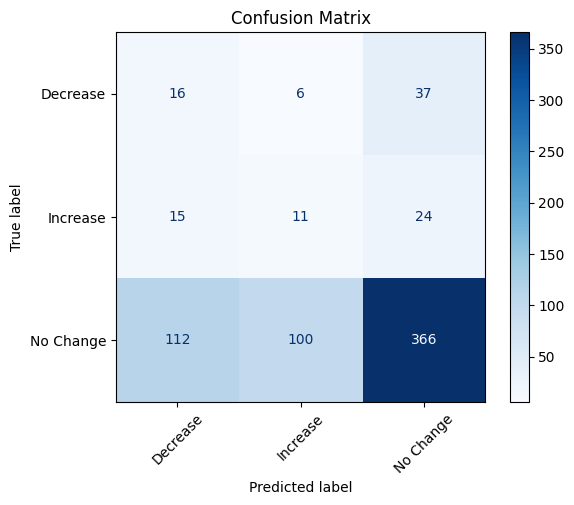


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.11      0.27      0.16        59
    Increase       0.09      0.22      0.13        50
   No Change       0.86      0.63      0.73       578

    accuracy                           0.57       687
   macro avg       0.35      0.37      0.34       687
weighted avg       0.74      0.57      0.64       687



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))